In [1]:
import os
import sys
import cv2
from math import pi
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D
import torchvision
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error
def pair(t):
    return t if isinstance(t, tuple) else (t, t)

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
print(os.environ['CUDA_VISIBLE_DEVICES'])

0


## Equi to Pers

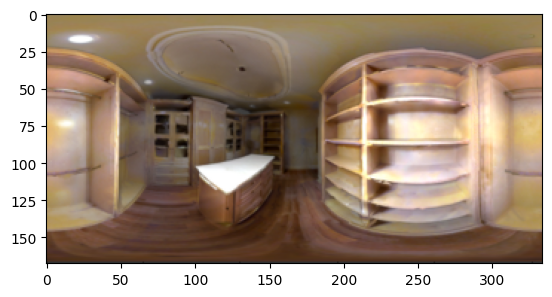

In [3]:
img = cv2.imread('pano4.png', cv2.IMREAD_COLOR)
#img = img.astype(np.float32) / 255
[erp_h, erp_w, _] = img.shape
plt.imshow(img[:,:,[2,1,0]])
plt.show()

In [4]:
img_new = img.astype(np.float32) / 255
img_new = np.transpose(img_new, [2, 0, 1])
img_new = torch.from_numpy(img_new)
img_new = img_new.unsqueeze(0)

In [5]:
height, width = 96, 96
FOV = [120, 120]
FOV = [FOV[0]/360.0, FOV[1]/180.0]
FOV = torch.tensor(FOV, dtype=torch.float32)
PI = math.pi
PI_2 = math.pi * 0.5
PI2 = math.pi * 2
yy, xx = torch.meshgrid(torch.linspace(0, 1, height), torch.linspace(0, 1, width))
screen_points = torch.stack([xx.flatten(), yy.flatten()], -1)
print(screen_points.shape)

torch.Size([9216, 2])


/home/sslunder0/anaconda3/envs/OmniDepth-v1-py311/lib/python3.11/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


### Processing

In [6]:


#num_rows = 6
#num_cols = [3, 8, 12, 12, 8, 3]
#phi_centers = [-75, -45, -15, 15, 45, 75]
#num_rows = 4
#num_cols = [3, 6, 6, 3]
#phi_centers = [-67.5, -22.5, 22.5, 67.5]
num_rows = 3
num_cols = [3, 4, 3]
phi_centers = [-60, 0, 60]
phi_interval = 180 // num_rows
all_combos = []
erp_mask = []
for i, n_cols in enumerate(num_cols):
    for j in np.arange(n_cols):
        theta_interval = 360 / n_cols
        theta_center = j * theta_interval + theta_interval / 2
        center = [theta_center, phi_centers[i]]
        all_combos.append(center)
        up = phi_centers[i] + phi_interval / 2
        down = phi_centers[i] - phi_interval / 2
        left = theta_center - theta_interval / 2
        right = theta_center + theta_interval / 2
        up = int((up + 90) / 180 * erp_h)
        down = int((down + 90) / 180 * erp_h)
        left = int(left / 360 * erp_w)
        right = int(right / 360 * erp_w)
        mask = np.zeros((erp_h, erp_w), dtype=int)
        mask[down:up, left:right] = 1
        erp_mask.append(mask)
all_combos = np.vstack(all_combos) 
shifts = np.arange(all_combos.shape[0]) * width
shifts = torch.from_numpy(shifts).float()
erp_mask = np.stack(erp_mask)
erp_mask = torch.from_numpy(erp_mask).float()
n_patch = all_combos.shape[0]
print(all_combos)

[[ 60. -60.]
 [180. -60.]
 [300. -60.]
 [ 45.   0.]
 [135.   0.]
 [225.   0.]
 [315.   0.]
 [ 60.  60.]
 [180.  60.]
 [300.  60.]]


In [7]:
center_point = torch.from_numpy(all_combos).float()  # -180 to 180, -90 to 90
center_point[:, 0] = (center_point[:, 0]) / 360  #0 to 1
center_point[:, 1] = (center_point[:, 1] + 90) / 180  #0 to 1


In [8]:
cp = center_point * 2 - 1
cp[:, 0] = cp[:, 0] * PI
cp[:, 1] = cp[:, 1] * PI_2
cp = cp.unsqueeze(1)
convertedCoord = screen_points * 2 - 1
convertedCoord[:, 0] = convertedCoord[:, 0] * PI
convertedCoord[:, 1] = convertedCoord[:, 1] * PI_2
convertedCoord = convertedCoord * (torch.ones(screen_points.shape, dtype=torch.float32) * FOV)
convertedCoord = convertedCoord.unsqueeze(0).repeat(cp.shape[0], 1, 1)
print(cp.shape)
print(convertedCoord.shape)

torch.Size([10, 1, 2])
torch.Size([10, 9216, 2])


In [9]:
x = convertedCoord[:, :, 0]
y = convertedCoord[:, :, 1]

rou = torch.sqrt(x ** 2 + y ** 2)
c = torch.atan(rou)
sin_c = torch.sin(c)
cos_c = torch.cos(c)
lat = torch.asin(cos_c * torch.sin(cp[:, :, 1]) + (y * sin_c * torch.cos(cp[:, :, 1])) / rou)
lon = cp[:, :, 0] + torch.atan2(x * sin_c, rou * torch.cos(cp[:, :, 1]) * cos_c - y * torch.sin(cp[:, :, 1]) * sin_c)
lat_new = lat / PI_2 
lon_new = lon / PI 
lon_new[lon_new > 1] -= 2
lon_new[lon_new<-1] += 2 

In [10]:
print(lon_new.shape, lat_new.shape)
lon_new = lon_new.view(1, n_patch, height, width).permute(0, 2, 1, 3).contiguous().view(height, n_patch*width)
lat_new = lat_new.view(1, n_patch, height, width).permute(0, 2, 1, 3).contiguous().view(height, n_patch*width)
grid = torch.stack([lon_new, lat_new], -1)


torch.Size([10, 9216]) torch.Size([10, 9216])


In [11]:
grid = grid.unsqueeze(0)
print(img_new.shape)
print(grid.shape)
persp = F.grid_sample(img_new, grid, mode='bilinear', padding_mode='zeros', align_corners=True)
print(persp.shape)

torch.Size([1, 3, 168, 334])
torch.Size([1, 96, 960, 2])
torch.Size([1, 3, 96, 960])


In [12]:
persp2 = F.unfold(persp, kernel_size=(height, width), stride=(height, width))
print(persp2.shape)
persp2 = persp2.reshape(1, -1, height, width, 10)
print(persp2.shape)

torch.Size([1, 27648, 10])
torch.Size([1, 3, 96, 96, 10])


(96, 960, 3)


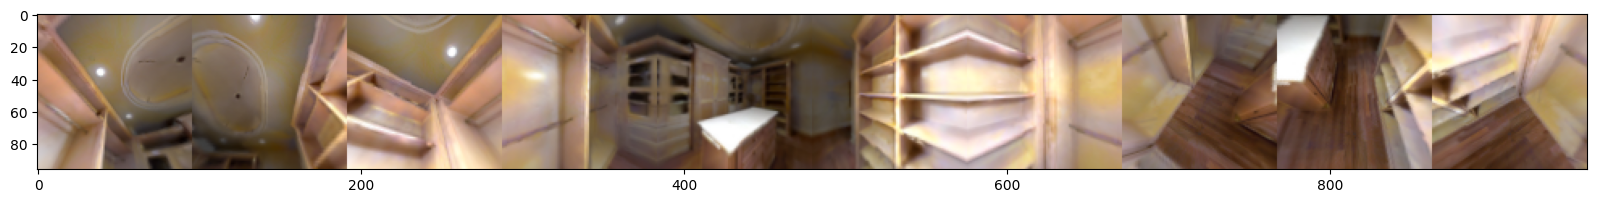

In [13]:
persp_int = persp[0].permute(1, 2, 0).numpy() #numpy로 이미지출력 시 C,H,W -> H,W,C 변경
persp_int = persp_int * 255 # 0~1을 0~255 및 타입 8bit으로
cv2.imwrite('pers.png', persp_int.astype(np.uint8))
print(persp_int.shape)
plt.figure(figsize=(20, 12))
plt.imshow(persp_int[:,:,[2,1,0]].astype(np.uint8), aspect=1) #cv2에선 RGB채널이 아닌 BGR이므로 
plt.show()

## Pers to Equi

In [14]:
lat_grid, lon_grid = torch.meshgrid(torch.linspace(-PI_2, PI_2, erp_h), torch.linspace(-PI, PI, erp_w))
lon_grid = lon_grid.float().reshape(1, -1)#.repeat(num_rows*num_cols, 1)
lat_grid = lat_grid.float().reshape(1, -1)#.repeat(num_rows*num_cols, 1) 

cos_c = torch.sin(cp[..., 1]) * torch.sin(lat_grid) + torch.cos(cp[..., 1]) * torch.cos(lat_grid) * torch.cos(lon_grid - cp[..., 0])
new_x = (torch.cos(lat_grid) * torch.sin(lon_grid - cp[..., 0])) / cos_c
new_y = (torch.cos(cp[..., 1])*torch.sin(lat_grid) - torch.sin(cp[...,1])*torch.cos(lat_grid)*torch.cos(lon_grid-cp[...,0])) / cos_c
new_x = new_x / FOV[0] / PI   # -1 to 1
new_y = new_y / FOV[1] / PI_2
print(new_x.shape, new_y.shape)
#new_x[new_x>1] = 0
#new_x[new_x<-1] = 0
#new_y[new_y>1] = 0
#new_y[new_y<-1] = 0

torch.Size([10, 56112]) torch.Size([10, 56112])


In [15]:
new_x = (new_x + 1) * 0.5 * height
new_y = (new_y + 1) * 0.5 * width
new_x = new_x.reshape(n_patch, erp_h, erp_w) 
new_y = new_y.reshape(n_patch, erp_h, erp_w) 

new_x = new_x + shifts.reshape(-1, 1, 1)
print(new_x.min(), new_x.max())
print(new_y.min(), new_y.max())

tensor(-2601201.5000) tensor(2602161.5000)
tensor(-4.4464e+11) tensor(4.4464e+11)


In [16]:
#new_x = new_x[15, :, :]
#new_y = new_y[15, :, :]
new_x *= erp_mask
new_y *= erp_mask
print(new_x.shape)
new_x = new_x.sum(0)
new_y = new_y.sum(0)
print(new_x.shape)

torch.Size([10, 168, 334])
torch.Size([168, 334])


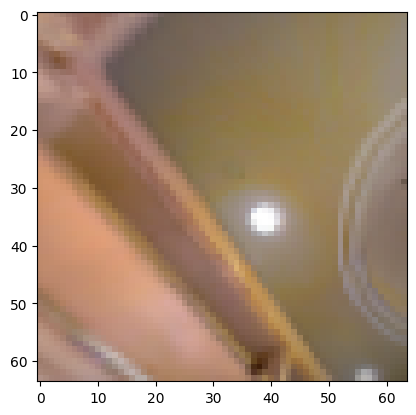

In [17]:
persp_patch = persp[:, :, :64, :64]
persp_patch = persp_patch[0].permute(1, 2, 0).numpy()
persp_patch = persp_patch * 255
plt.imshow(persp_patch[:,:,[2,1,0]].astype(np.uint8), aspect=1)
plt.show()

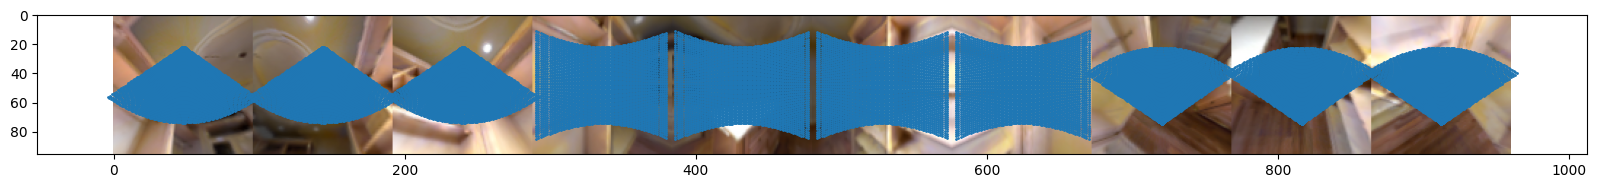

In [18]:
plt.figure(figsize=(20, 12))
plt.imshow(persp_int[:,:,[2,1,0]].astype(np.uint8), aspect=1)
plt.scatter(new_x.flatten(), new_y.flatten(), s=1)
plt.show()

In [19]:
new_x = (new_x / persp.shape[-1] - 0.5) * 2
new_y = (new_y / persp.shape[-2] - 0.5) * 2
print(new_x.min(), new_x.max())
print(new_y.min(), new_y.max())
new_grid = torch.stack([new_x, new_y], -1)
new_grid = new_grid.unsqueeze(0)
img_erp = F.grid_sample(persp, new_grid, mode='bilinear', padding_mode='border', align_corners=True)

tensor(-1.0082) tensor(1.0082)
tensor(-0.7721) tensor(0.7721)


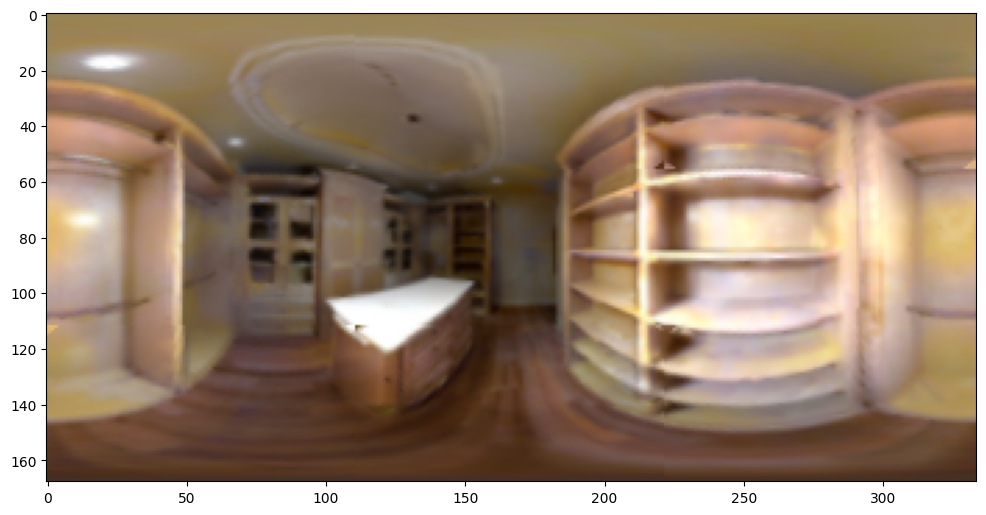

In [20]:
img_erp_int = img_erp[0].permute(1, 2, 0).numpy()
img_erp_int = img_erp_int * 255
img_erp_int = img_erp_int[:,:,[2,1,0]].astype(np.uint8)
plt.figure(figsize=(12, 12))
plt.imshow(img_erp_int, aspect=1)
plt.show()

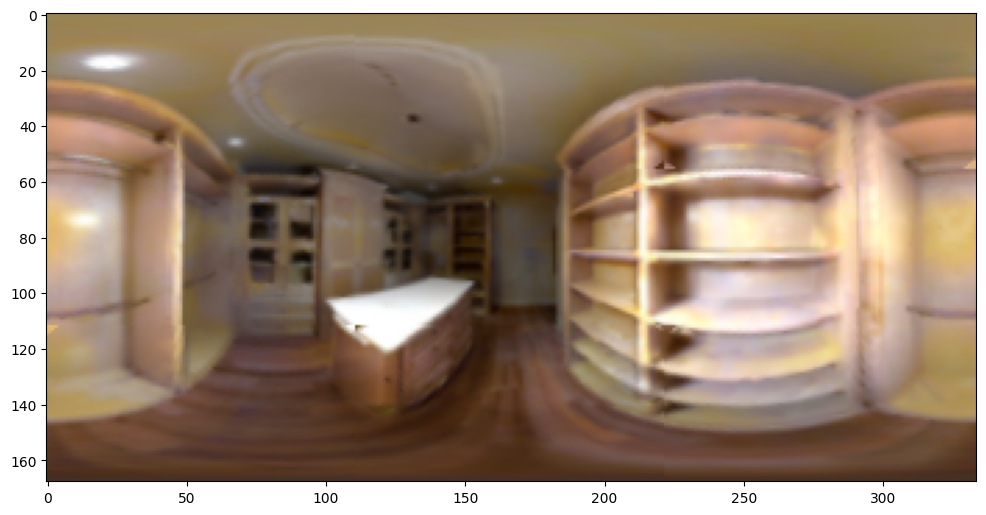

In [24]:
#total
lat_grid, lon_grid = torch.meshgrid(torch.linspace(-PI_2, PI_2, erp_h), torch.linspace(-PI, PI, erp_w))
lon_grid = lon_grid.float().reshape(1, -1)#.repeat(num_rows*num_cols, 1)
lat_grid = lat_grid.float().reshape(1, -1)#.repeat(num_rows*num_cols, 1) 

cos_c = torch.sin(cp[..., 1]) * torch.sin(lat_grid) + torch.cos(cp[..., 1]) * torch.cos(lat_grid) * torch.cos(lon_grid - cp[..., 0])
new_x = (torch.cos(lat_grid) * torch.sin(lon_grid - cp[..., 0])) / cos_c
new_y = (torch.cos(cp[..., 1])*torch.sin(lat_grid) - torch.sin(cp[...,1])*torch.cos(lat_grid)*torch.cos(lon_grid-cp[...,0])) / cos_c
new_x = new_x / FOV[0] / PI   # -1 to 1
new_y = new_y / FOV[1] / PI_2

new_x = (new_x + 1) * 0.5 * height
new_y = (new_y + 1) * 0.5 * width
new_x = new_x.reshape(n_patch, erp_h, erp_w) 
new_y = new_y.reshape(n_patch, erp_h, erp_w) 

new_x = new_x + shifts.reshape(-1, 1, 1) # moving

new_x *= erp_mask # masking
new_y *= erp_mask
new_x = new_x.sum(0)
new_y = new_y.sum(0)

new_x = (new_x / persp.shape[-1] - 0.5) * 2
new_y = (new_y / persp.shape[-2] - 0.5) * 2
new_grid = torch.stack([new_x, new_y], -1)
new_grid = new_grid.unsqueeze(0)
img_erp = F.grid_sample(persp, new_grid, mode='bilinear', padding_mode='border', align_corners=True)

#Visualize
img_erp_int = img_erp[0].permute(1, 2, 0).numpy()
img_erp_int = img_erp_int * 255
img_erp_int = img_erp_int[:,:,[2,1,0]].astype(np.uint8)
plt.figure(figsize=(12, 12))
plt.imshow(img_erp_int, aspect=1)
plt.show()

In [22]:
ssim_noise = ssim(img, img_erp_int, multichannel=True)
print(ssim_noise)
mse_noise = mean_squared_error(img, img_erp_int)
print(mse_noise)

ValueError: win_size exceeds image extent. Either ensure that your images are at least 7x7; or pass win_size explicitly in the function call, with an odd value less than or equal to the smaller side of your images. If your images are multichannel (with color channels), set channel_axis to the axis number corresponding to the channels.

## Understand Grid space, Sampling
1. grid sampling

1-1. grid

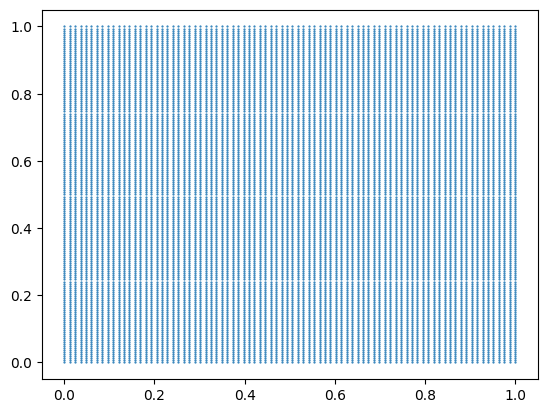

In [ ]:
height = 84
width = 167
### make (1x100) 1D space
x = torch.linspace(0, 1, width)
y = torch.linspace(0, 1, height)

#print(x.shape, y.shape)
#plt.scatter(x, y, s=1)
#plt.show()

### make (100x100) 2D space
(row, col) = torch.meshgrid(torch.linspace(0, 1, 4), torch.linspace(2, 3, 8)) # 행, 열 조건
#print(yy.shape, xx.shape)
# plt.scatter(x=col, y=row, s=1)
# plt.show()


### make 3D space
#fig, ax1 = plt.subplots(1, 1, subplot_kw={"projection":"3d"})
(row, col, zz) = torch.meshgrid(torch.linspace(0, 1, 4), torch.linspace(2, 3, 8), torch.linspace(5, 6, 10)) 
#print(row.shape)
# ax1.scatter3D(col, row, zz, s=1)
# plt.show()


(H, W) = torch.meshgrid(torch.linspace(0, 1, height), torch.linspace(0, 1, width)) #(100, 100) 2D space
plt.scatter(H, W, s=0.3)
plt.show()

In [ ]:
screen_points = torch.stack([W.flatten(), H.flatten()], -1)
print(screen_points.shape)
grid = screen_points.unsqueeze(0).reshape(1, height, width, 2)
print(grid.shape)


torch.Size([14028, 2])
torch.Size([1, 84, 167, 2])


In [ ]:
(H2, W2) = torch.meshgrid(torch.linspace(-1, 0, height), torch.linspace(-1, 0, width)) #(100, 100) 2D space
grid2 = torch.stack([H2, W2], -1).unsqueeze(0)
print(grid2.shape)

grid_sum = torch.cat([grid, grid2], 0)
print(grid_sum.shape)

grid_sum2 = torch.cat([grid, grid2], 2)
print(grid_sum2.shape)

torch.Size([1, 96, 96, 2])
torch.Size([2, 96, 96, 2])
torch.Size([1, 96, 192, 2])


1-2. sampling

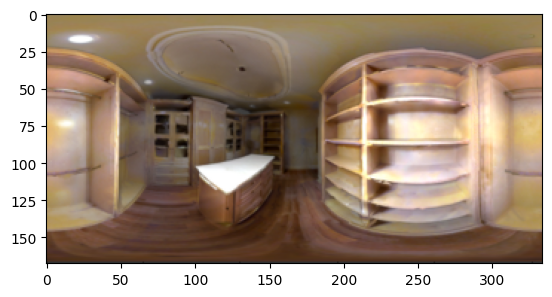

image: torch.Size([1, 3, 168, 334])
pers: torch.Size([1, 3, 96, 192])
(96, 192, 3)


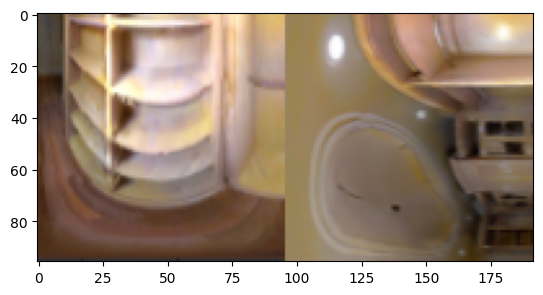

In [ ]:
img = cv2.imread('pano4.png', cv2.IMREAD_COLOR)
#img = img.astype(np.float32) / 255
[erp_h, erp_w, _] = img.shape
plt.imshow(img[:,:,[2,1,0]])
plt.show()

img_new = img.astype(np.float32) / 255
img_new = np.transpose(img_new, [2, 0, 1])
img_new = torch.from_numpy(img_new)
img_new = img_new.unsqueeze(0)
print(f'image: {img_new.shape}') #image: torch.Size([1, 3, 168, 334])
persp = F.grid_sample(img_new, grid_sum2, mode='bilinear', padding_mode='zeros', align_corners=True)

print(f"pers: {persp.shape}") #pers: torch.Size([1, 3, 96, 96])

persp_int = persp[0].permute(1, 2, 0).numpy()
persp_int = persp_int * 255
cv2.imwrite('pers.png', persp_int.astype(np.uint8))
print(persp_int.shape)
#plt.figure(figsize=(20, 12))
plt.imshow(persp_int[:,:,[2,1,0]].astype(np.uint8), aspect=1)
plt.show()


1-3. Fusion

In [ ]:
print(persp.shape)

yy_, xx_ = torch.meshgrid(torch.linspace(0, 1, 168), torch.linspace(0, 1, 334))
screen_points = torch.stack([xx_.flatten(), yy_.flatten()], -1)
grid_rev = screen_points.unsqueeze(0).reshape(1, 168, 334, 2)
print(grid_rev.shape)
erp_rev = F.grid_sample(persp, grid_rev, mode='bilinear', padding_mode='zeros', align_corners=True)
print(erp_rev.shape)

torch.Size([1, 3, 96, 192])
torch.Size([1, 168, 334, 2])
torch.Size([1, 3, 168, 334])


(168, 334, 3)


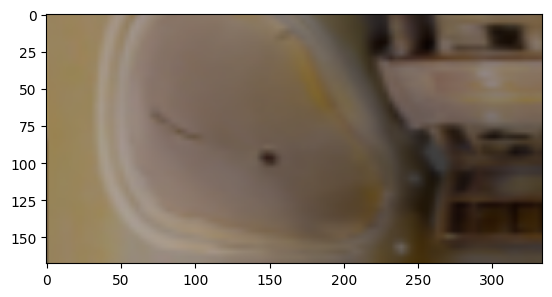

In [ ]:
persp_int = erp_rev[0].permute(1, 2, 0).numpy()
persp_int = persp_int * 255
cv2.imwrite('pers.png', persp_int.astype(np.uint8))
print(persp_int.shape)
#plt.figure(figsize=(20, 12))
plt.imshow(persp_int[:,:,[2,1,0]].astype(np.uint8), aspect=1)
plt.show()

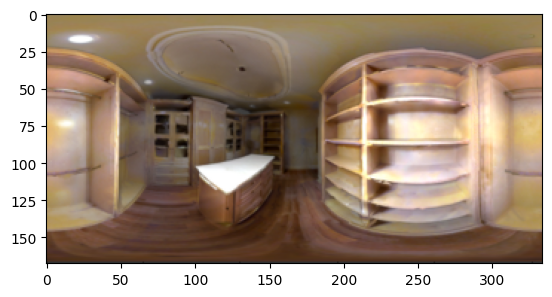

image: torch.Size([1, 3, 168, 334])
torch.Size([9216, 2])
grid: torch.Size([1, 96, 96, 2])
pers: torch.Size([1, 3, 96, 96])
(96, 96, 3)


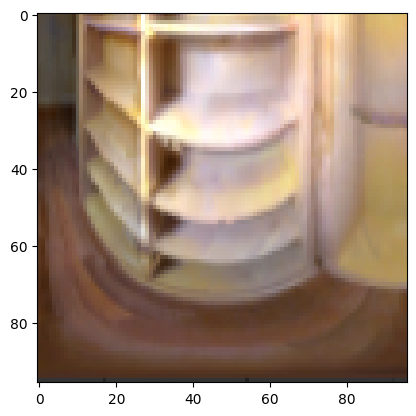

In [78]:
img = cv2.imread('pano4.png', cv2.IMREAD_COLOR)
#img = img.astype(np.float32) / 255
[erp_h, erp_w, _] = img.shape
plt.imshow(img[:,:,[2,1,0]])
plt.show()

img_new = img.astype(np.float32) / 255
img_new = np.transpose(img_new, [2, 0, 1])
img_new = torch.from_numpy(img_new)
img_new = img_new.unsqueeze(0)
print(f'image: {img_new.shape}') #image: torch.Size([1, 3, 168, 334])

## Grid
height, width = 96, 96
yy, xx = torch.meshgrid(torch.linspace(0, 1, height), torch.linspace(0, 1, width))
screen_points = torch.stack([xx.flatten(), yy.flatten()], -1)
print(screen_points.shape) #torch.Size([9216, 2])
grid = screen_points.unsqueeze(0)
grid = grid.reshape(1, 96, 96, 2)
print(f'grid: {grid.shape}') #grid: torch.Size([1, 96, 96, 2])

## Sample
persp = F.grid_sample(img_new, grid, mode='bilinear', padding_mode='zeros', align_corners=True)
print(f"pers: {persp.shape}") #pers: torch.Size([1, 3, 96, 96])

persp_int = persp[0].permute(1, 2, 0).numpy()
persp_int = persp_int * 255
cv2.imwrite('pers.png', persp_int.astype(np.uint8))
print(persp_int.shape)
#plt.figure(figsize=(20, 12))
plt.imshow(persp_int[:,:,[2,1,0]].astype(np.uint8), aspect=1)
plt.show()